In [1]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import custom_layers
from sklearn.metrics import confusion_matrix

tf.config.list_physical_devices('GPU')

[]

In [2]:
PATH_KVASIR = 'E:\\Gastroscopies\\hyper_kvasir\\upper-gi-tract\\anatomical-landmarks'
MODEL_PATH = 'MODEL_INCEPTIONV3'
batch_size = 32
LR = 0.00005
img_height = 500
img_width = 500

In [3]:
# load pre-trained (imagenet) InceptionV3 model
InceptionV3 = tf.keras.applications.InceptionV4(include_top=False, weights='imagenet', input_shape =(img_height, img_width, 3))

In [4]:
# tf.keras.utils.plot_model(InceptionV3 , to_file='InceptionV3.png', show_shapes=True, show_layer_names=True)

In [5]:
kvasir_dir = pathlib.Path(PATH_KVASIR)

train_ds = tf.keras.utils.image_dataset_from_directory(
    kvasir_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    kvasir_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

labels = train_ds.class_names
print(labels)

Found 2695 files belonging to 3 classes.
Using 2426 files for training.
Found 2695 files belonging to 3 classes.
Using 269 files for validation.
['pylorus', 'retroflex-stomach', 'z-line']


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    custom_layers.Random90Rotation(),
    custom_layers.RandomHue(),
    #custom_layers.RandomGaussian()
])

In [7]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
  tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)
])

In [8]:
dense_end = tf.keras.Sequential([
    # https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3)
])

prediction_layer = tf.keras.layers.Dense(3,activation='softmax')

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = InceptionV3(x)
x = dense_end(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# initially freeze DenseNet to avoid overfitting, will unfreeze during fine-tuning 
for layer in model.layers[:-2]:
    layer.trainable=False 
    
for layer in model.layers[-2:]:
    layer.trainable=True

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 500, 500, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 500, 500, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
sequential_2 (Sequential)    (None, 512)               2633216   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 24,437,539
Trainable params: 2,629,635
Non-trainable params: 21,807,904
_________________________________________

(-0.5, 499.5, 499.5, -0.5)

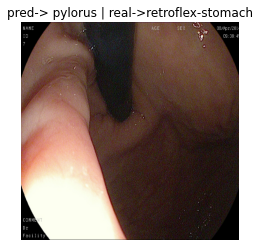

In [11]:
### TEST UNTRAINED MODEL ###
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))
pred = model.predict(image_batch)

source = image_batch[0].numpy()/255
index_pred = np.argmax(pred[0])
index_real = label_batch[0]

plt.imshow(source)
plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
plt.axis("off")

In [12]:
# Defines fit callbacks
checkpoint =  tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_accuracy',save_weights_only=True, save_best_only=True)
early =  tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=2, min_lr=LR/10, verbose=1)
fit_callbacks = [checkpoint,early,plateau]

In [13]:
history_start = model.fit(
    train_ds,
    epochs=8,
    validation_data=val_ds,
    callbacks=fit_callbacks
)

for layer in model.layers[:-2]:
    layer.trainable=True
    
history_fine_tuning = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=fit_callbacks
)

for layer in model.layers[:-2]:
    layer.trainable=False

history_end = model.fit(
    train_ds,
    epochs=4,
    validation_data=val_ds,
    callbacks=fit_callbacks
)



Epoch 1/8
76/76 [==============================] - 823s 11s/step - loss: 0.5315 - accuracy: 0.7943 - val_loss: 0.6644 - val_accuracy: 0.8178
Epoch 2/8
76/76 [==============================] - 682s 9s/step - loss: 0.1775 - accuracy: 0.9378 - val_loss: 0.4322 - val_accuracy: 0.8922
Epoch 3/8
76/76 [==============================] - 699s 9s/step - loss: 0.1329 - accuracy: 0.9493 - val_loss: 0.2314 - val_accuracy: 0.9480
Epoch 4/8
76/76 [==============================] - 678s 9s/step - loss: 0.0901 - accuracy: 0.9646 - val_loss: 0.1261 - val_accuracy: 0.9665
Epoch 5/8
76/76 [==============================] - 651s 9s/step - loss: 0.0764 - accuracy: 0.9695 - val_loss: 0.0813 - val_accuracy: 0.9740
Epoch 6/8
76/76 [==============================] - 666s 9s/step - loss: 0.0572 - accuracy: 0.9769 - val_loss: 0.0581 - val_accuracy: 0.9814
Epoch 7/8
76/76 [==============================] - 692s 9s/step - loss: 0.0704 - accuracy: 0.9753 - val_loss: 0.0545 - val_accuracy: 0.9851
Epoch 8/8
76/76 [==

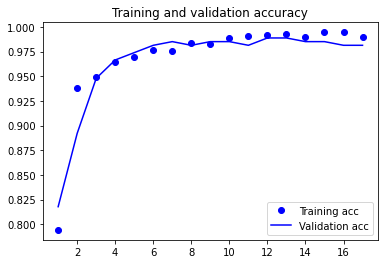

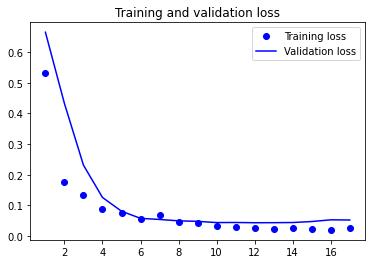

In [22]:
### Training Plots ###
acc = history_start.history['accuracy']
val_acc = history_start.history['val_accuracy']
loss = history_start.history['loss']
val_loss = history_start.history['val_loss']

acc = np.hstack([acc,history_fine_tuning.history['accuracy']])
val_acc = np.hstack([val_acc,history_fine_tuning.history['val_accuracy']])
loss = np.hstack([loss,history_fine_tuning.history['loss']])
val_loss = np.hstack([val_loss,history_fine_tuning.history['val_loss']])

acc = np.hstack([acc,history_end.history['accuracy']])
val_acc = np.hstack([val_acc,history_end.history['val_accuracy']])
loss = np.hstack([loss,history_end.history['loss']])
val_loss = np.hstack([val_loss,history_end.history['val_loss']])

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

9/9 [==============================] - 62s 7s/step - loss: 0.0527 - accuracy: 0.9814


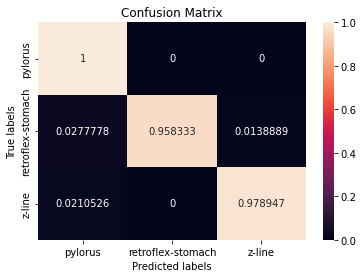

In [15]:
### model evaluation ###
#model = tf.keras.models.load_model(MODEL_PATH)
model.evaluate(val_ds)
#model.save(MODEL_PATH)

validation_iterator = iter(val_ds)
pred_label = np.array([])
true_label = np.array([])
while True:
    image_batch, label_batch = validation_iterator.get_next()
    pred_label = np.append(pred_label,model.predict(image_batch).argmax(1))
    true_label = np.append(true_label,label_batch)
    if len(image_batch) != batch_size : 
        break
        
pred_label = np.array([labels[int(x)] for x in pred_label])
true_label = np.array([labels[int(x)] for x in true_label])

cm = confusion_matrix(true_label, pred_label, normalize='true')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


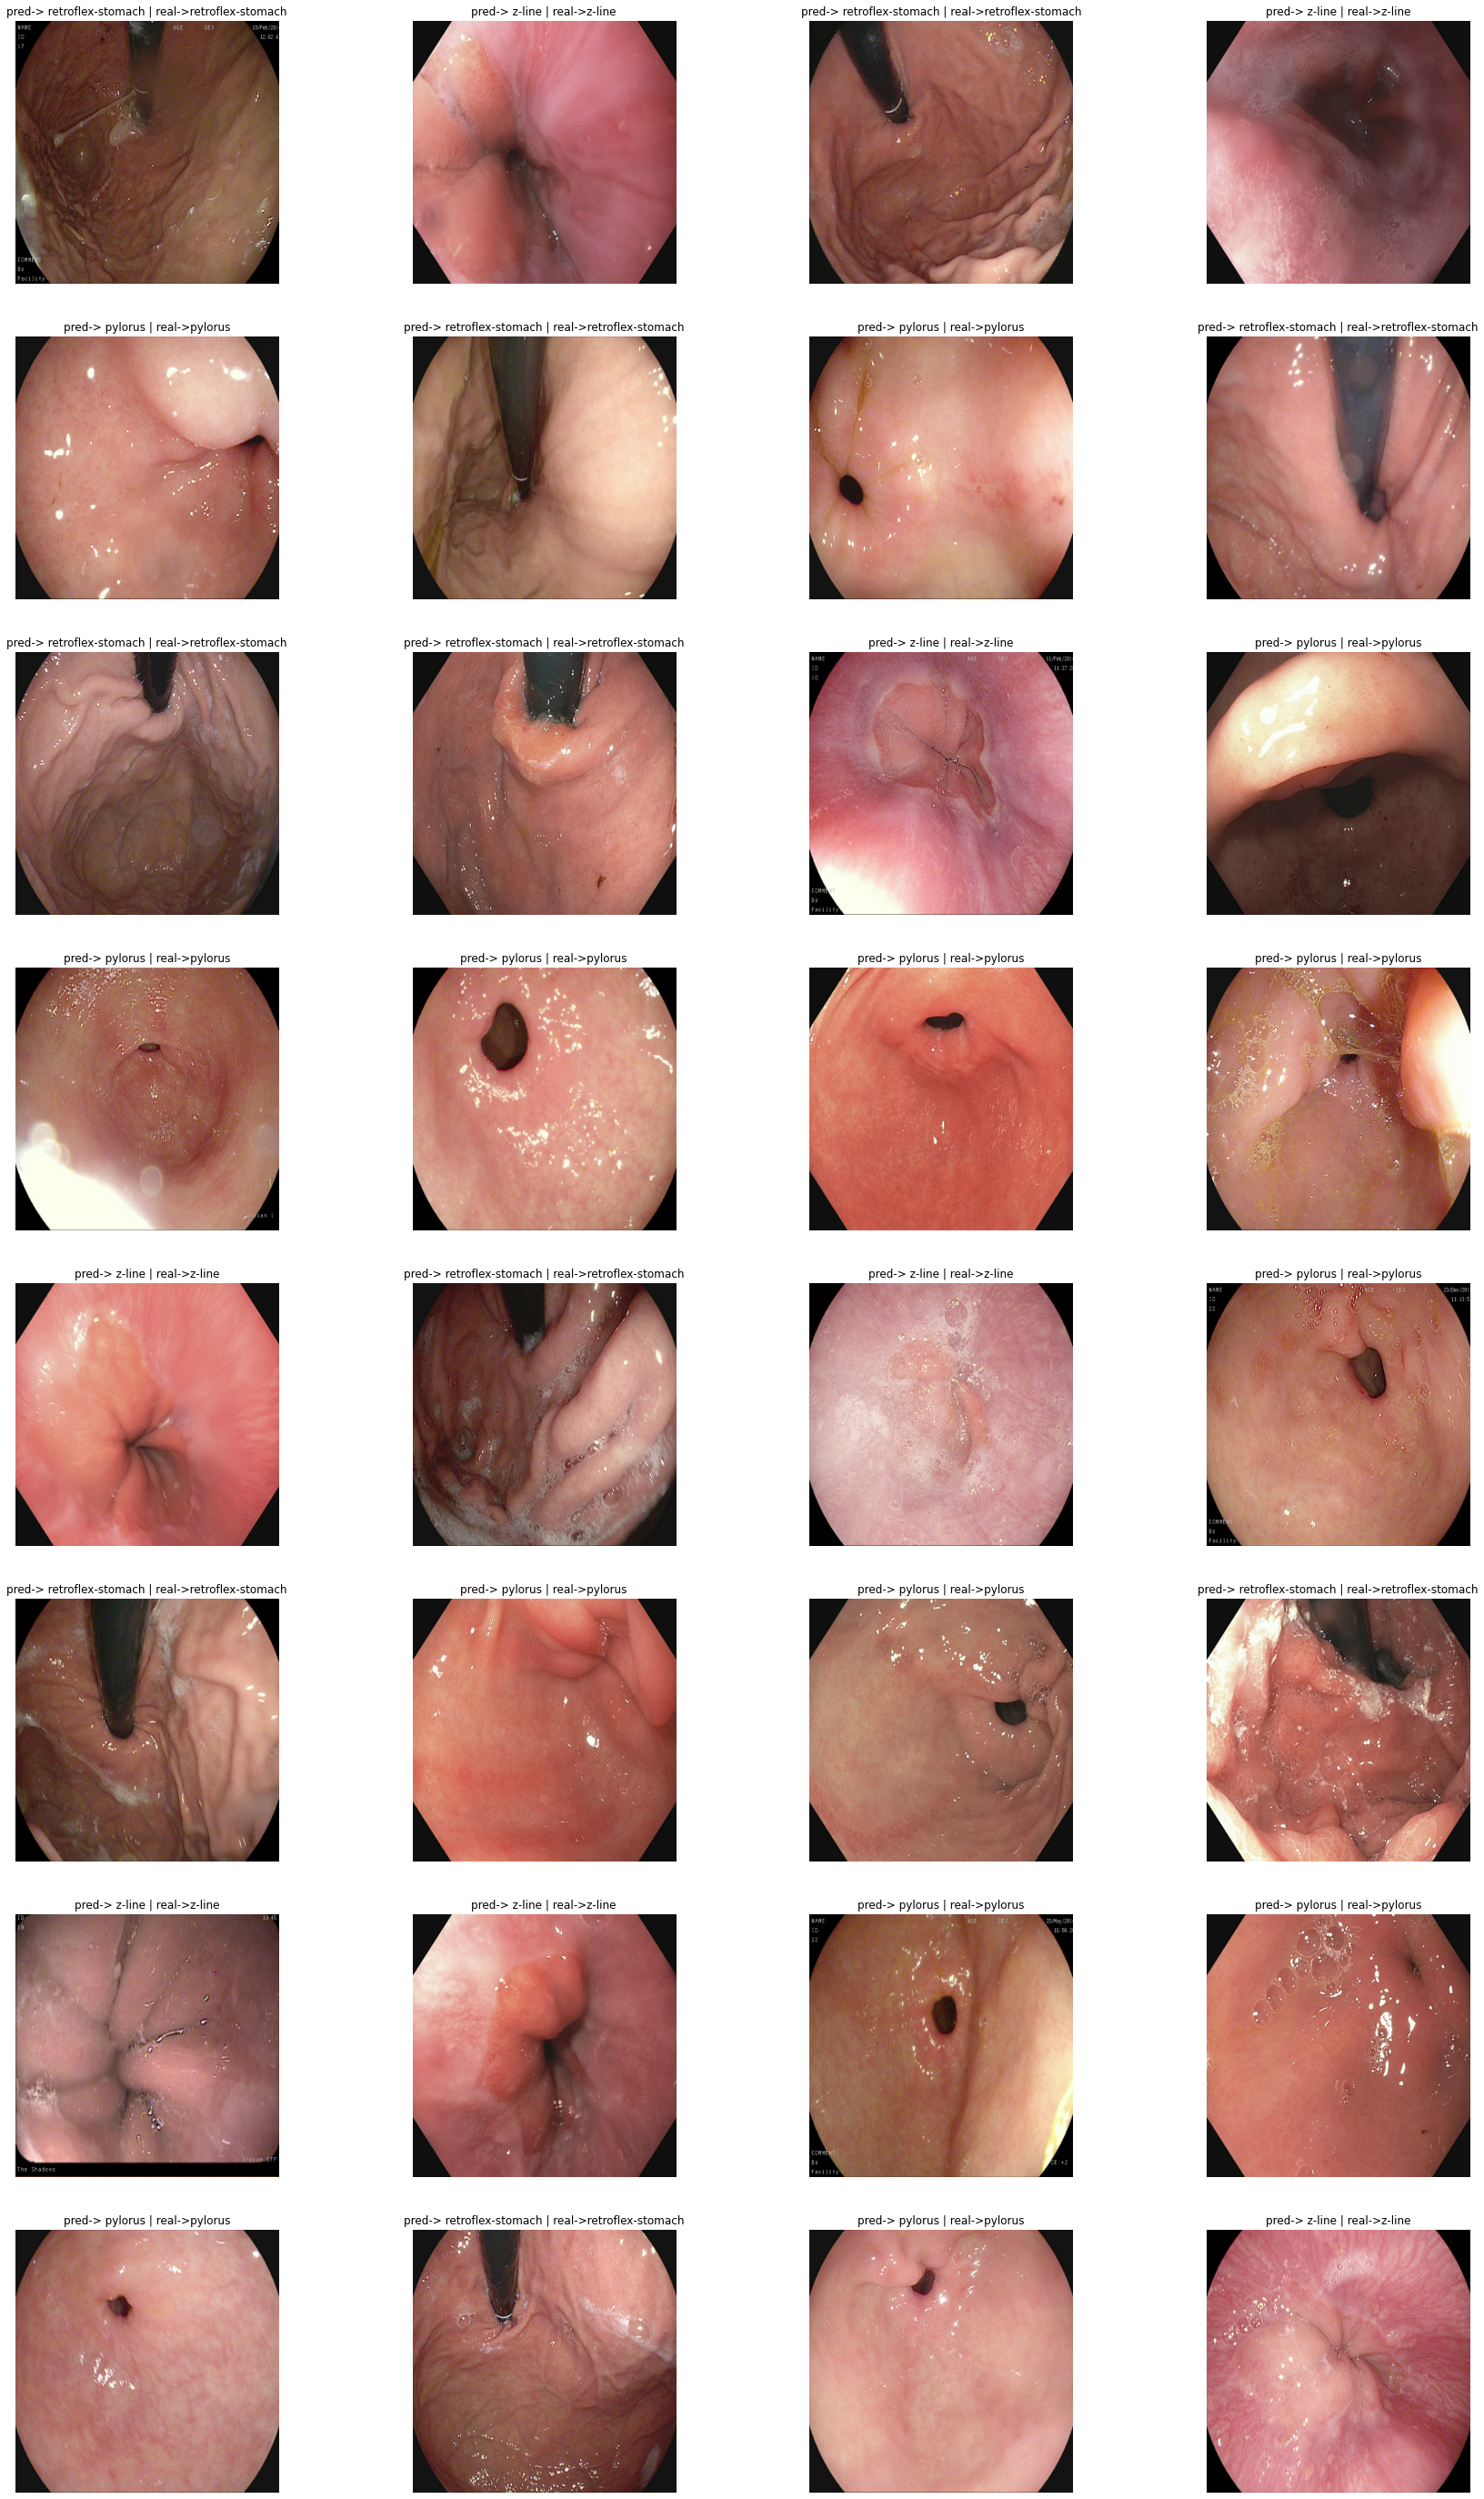

In [16]:
### EXAMPLE TRAINED MODEL ###

image_batch, label_batch = next(iter(train_ds))
pred = model.predict(image_batch)

rows, columns = 8, 4

fig = plt.figure(figsize=(30, 50))
for i in range(len(image_batch)):
    fig.add_subplot(rows,columns, i+1)
    
    source = image_batch[i].numpy()/255
    index_pred = np.argmax(pred[i])
    index_real = label_batch[i]

    plt.imshow(source)
    plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
    plt.axis("off")

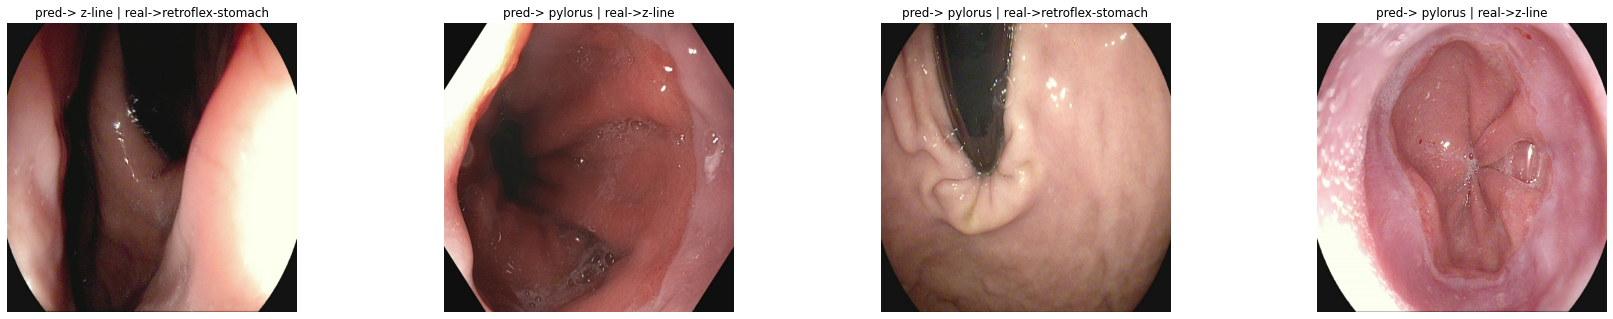

In [17]:
### model evaluation failures ###

fig = plt.figure(figsize=(30, 50))
rows, columns = 8, 4
validation_iterator = iter(val_ds)
pred_label = np.array([])
true_label = np.array([])
i = 0
j = 0
while True:
    image_batch, label_batch = validation_iterator.get_next()
    pred = model.predict(image_batch)
    index_pred = np.argmax(pred[i])
    index_real = label_batch[i]
    if len(image_batch) != batch_size : 
        break
    for k in range(len(image_batch)):
        source = image_batch[k].numpy()/255
        index_pred = np.argmax(pred[k])
        index_real = label_batch[k]
        if index_pred != index_real:
            fig.add_subplot(rows,columns,j+1)
            plt.imshow(source)
            plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
            plt.axis("off")
            j+=1
    i+=1

In [18]:
### Test on study set ###

PATH_ETUDE = 'E:\\Gastroscopies\\Etude\\Train'

etude_dir = pathlib.Path(PATH_ETUDE)

etude_ds = tf.keras.utils.image_dataset_from_directory(
    etude_dir,
    validation_split=0.05,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

etude_ds = etude_ds.cache().prefetch(buffer_size=AUTOTUNE)


model.evaluate(etude_ds)

Found 291 files belonging to 3 classes.
Using 277 files for training.
9/9 [==============================] - 67s 7s/step - loss: 0.2859 - accuracy: 0.9242


[0.2859167754650116, 0.9241877198219299]